# Cantilever (no scale)

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import *
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.015002965927124023


3 coordinate transform: 6.598384618759155
2 read results: 9.002907514572144
1 total mesh and result loading: 9.183467149734497
1 total edge processing: 0.3949551582336426
(1, 5)


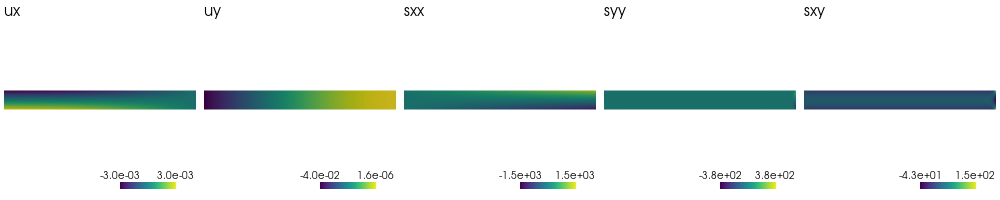

In [2]:
# load mesh and solver results
op2File = 'data/cantilever/v1.0/cantilever01.op2'
geom = MeshGeom(op2File, thickness=0.05, center=False, scale=False)

plotScalarFields(geom.mesh, geom.resDf, shape=(1,5), size=200)

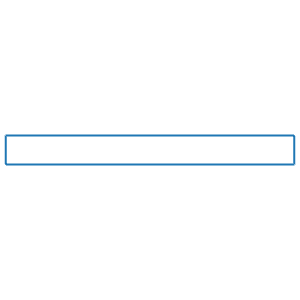

In [5]:
drawBoundaries(geom.bndDict)

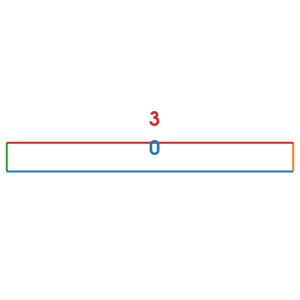

In [6]:
# by default every continuous edge forms a single boundary. We can further split the boundary like this
mask = getCellMask(geom.bndDict[0], component=0, func=lambda x: (x[:,0]>0.997).all())
newBndDict, newBndNormsDict = splitBoundary(geom.bndDict, geom.bndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,0]<0.002).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,1]>0.0).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

drawBoundaries(newBndDict)

In [7]:
# now update the boundary metadata
geom.bndDict, geom.bndNormsDict = newBndDict, newBndNormsDict
geom.updateBndLengthAndArea()

### scale data-driven terms to 1 and all others to 1e-8 to track them over time

Compiling model...
Building feed-forward neural network...
'build' took 0.044878 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.015536 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [8.51e+04, 6.04e-01, 1.40e+04, 2.84e+05, 3.65e+01, 6.57e-08, 6.00e-08, 6.51e-01, 7.92e+01, 6.05e+01, 3.97e+02, 2.96e+00, 8.34e+01, 1.75e-06, 3.85e-04, 1.98e+05, 4.00e+02, 5.35e+02]    [8.56e+04, 5.99e-01, 1.22e+04, 2.85e+05, 2.95e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 5.82e+05
  test loss: 3.83e+05
  test metric: []

'train' took 0.211434 s

Compiling model...
'compile' took 0.732041 

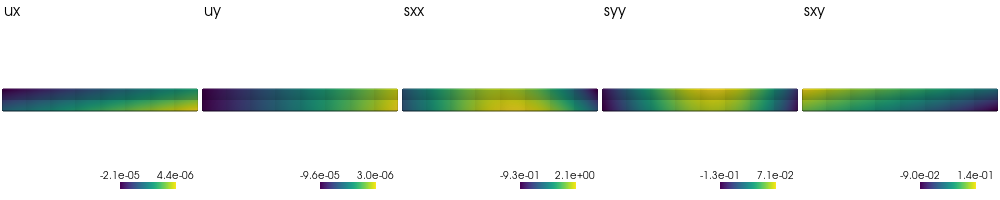

In [8]:
# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# train on dense point cloud
X_train = X_test
y_train = y_test

# supports
xBc = SupportBC(geom, bndId=1, U=0, component=0)
yBc = SupportBC(geom, bndId=1, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# external loads
xTr2 = TractionBC(geom, bndId=2, T=0, component=0)
yTr2 = TractionBC(geom, bndId=2, T=-21*.00475/geom.bndAreaDict[2], component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
bndNumSamplesDir = {0:150, 1:150, 2:150, 3:150}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=2400, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e3, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw[13:] *= 1e-8

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=500, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

(1, 5)


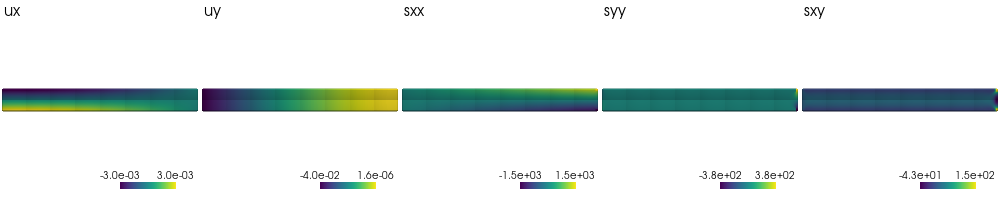

In [9]:
plotScalarFields(pc, geom.resDf)

In [10]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr2','yTr2','xTr3','yTr3','ux','uy','sxx','syy','sxy']
lossPlot(losshistory, bcNames, dropFirstStep=True, scaleType='log').properties(width=600, height=600)

alt.Chart(...)

Compiling model...
Building feed-forward neural network...
'build' took 0.042885 s

'compile' took 0.953469 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [1.77e+04, 1.17e+02, 5.02e+03, 8.09e+03, 8.17e+03, 5.73e-08, 1.56e-06, 3.61e+01, 4.64e+02, 4.18e+01, 3.99e+02, 2.89e+01, 3.90e+02, 1.77e-06, 3.73e-04, 1.78e+05, 7.56e+02, 7.19e+02]    [1.78e+04, 1.17e+02, 4.35e+03, 7.73e+03, 8.22e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 2.20e+05
  test loss: 3.83e+04
  t

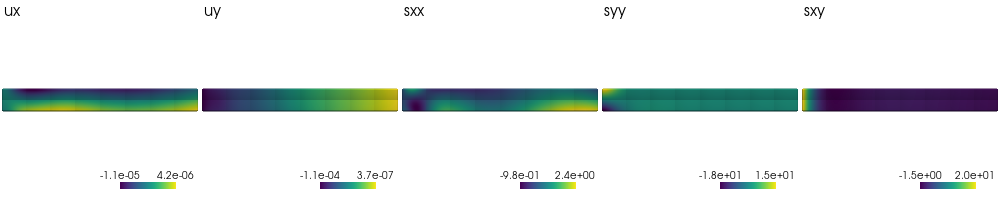

In [13]:
# test on FEA nodes
X_test = np.array(geom.mesh.points[:,:2])
y_test = geom.resDf.drop(columns='vonMises').values

# train on dense point cloud
X_train = X_test
y_train = y_test

# supports
xBc = SupportBC(geom, bndId=1, U=0, component=0)
yBc = SupportBC(geom, bndId=1, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# external loads
xTr2 = TractionBC(geom, bndId=2, T=0, component=0)
yTr2 = TractionBC(geom, bndId=2, T=-21*.00475/geom.bndAreaDict[2], component=1)

# PointSetBC class implements data-driven terms as a BC object
ux = dde.boundary_conditions.PointSetBC(X_train, y_train[:,0].reshape(-1,1), component=0)
uy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,1].reshape(-1,1), component=1)
sxx = dde.boundary_conditions.PointSetBC(X_train, y_train[:,2].reshape(-1,1), component=2)
syy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,3].reshape(-1,1), component=3)
sxy = dde.boundary_conditions.PointSetBC(X_train, y_train[:,4].reshape(-1,1), component=4)

# problem setup
bndNumSamplesDir = {0:150, 1:150, 2:150, 3:150}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3,ux,uy,sxx,syy,sxy]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=2400, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e3, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw[10] *= 10
lw[13:] *= 1e-8

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=2000, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

(1, 5)


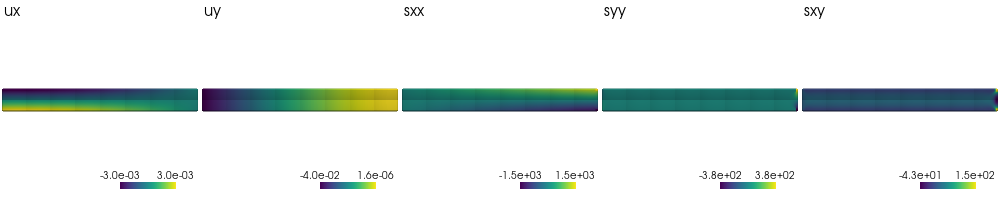

In [16]:
plotScalarFields(pc, geom.resDf)

In [15]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr2','yTr2','xTr3','yTr3','ux','uy','sxx','syy','sxy']
lossPlot(losshistory, bcNames, dropFirstStep=True, scaleType='log').properties(width=600, height=600)

alt.Chart(...)

Compiling model...
'compile' took 0.793604 s

Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
2000      [2.63e-03, 9.51e-03, 9.22e-04, 1.62e-03, 4.53e-04, 1.19e-04, 1.17e-08, 2.42e-01, 2.29e-02, 1.06e-04, 4.06e-04, 2.67e-01, 1.94e-02, 9.84e-09, 1.02e-08, 9.88e-09, 4.30e-09, 6.60e-09]    [2.00e-03, 7.80e-03, 6.53e-04, 1.45e-03, 4.08e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2100      [2.00e-03, 5.57e-03, 5.19e-04, 1.37e-03, 6.06e-04, 8.27e-05, 5.15e-06, 2.42e-01, 2.24e-02, 2.13e-04, 4.52e-05, 2.65e-01, 1.91e-02, 9.84e-09, 1.02e-08, 9

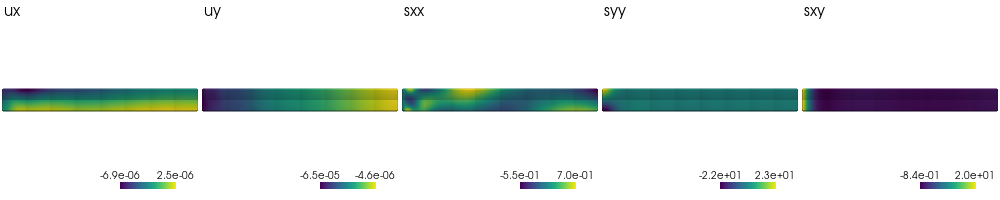

In [17]:
# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=2000, display_every=100)

# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

In [18]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr2','yTr2','xTr3','yTr3','ux','uy','sxx','syy','sxy']
lossPlot(losshistory, bcNames, dropFirstStep=True, scaleType='log').properties(width=600, height=600)

alt.Chart(...)

In [19]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=1000
model.train_op.optimizer_kwargs['options']['maxfun']=1000
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 0.650523 s

Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
4000      [1.96e-03, 4.11e-03, 9.58e-04, 1.89e-03, 8.54e-04, 2.86e-05, 1.53e-05, 2.07e-01, 3.06e-02, 1.93e-04, 6.51e-04, 2.01e-01, 2.95e-02, 9.86e-09, 1.02e-08, 9.87e-09, 4.35e-09, 6.59e-09]    [6.52e-04, 1.85e-03, 7.62e-04, 1.11e-03, 5.88e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4100      [1.04e-03, 3.27e-03, 5.74e-04, 1.30e-03, 6.48e-04, 3.54e-05, 4.13e-06, 2.01e-01, 3.37e-02, 5.29e-04, 1.32e-03, 1.90e-01, 3.24e-02, 9.86e-09, 1.02e-08, 9

(1, 5)


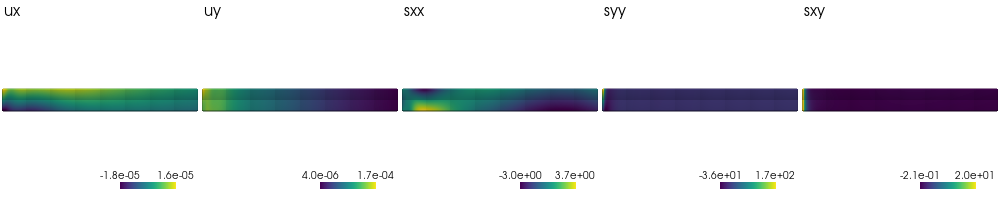

In [20]:
# test
pred = model.predict(X_train)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(X_train))
plotScalarFields(pc, predDf, bndDict=geom.bndDict)

In [21]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr2','yTr2','xTr3','yTr3','ux','uy','sxx','syy','sxy']
lossPlot(losshistory, bcNames, dropFirstStep=True, scaleType='log').properties(width=600, height=600)

alt.Chart(...)

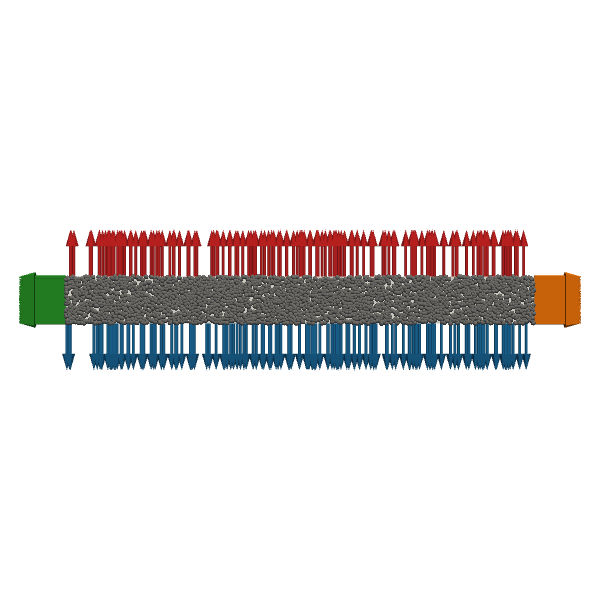

In [10]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');